In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [3]:
#데이터 준비
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
#데이터준비2
train_dataset = datasets.MNIST(root="Data/mnist",
                               train=True,
                               download=True,
                               transform=transform)

test_dataset = datasets.MNIST(root="Data/mnist",
                               train=False,
                               download=True,
                               transform=transform)

In [5]:
##데이터준비3
train_loder = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=32,
                                          shuffle=True)

test_loder = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=True)

In [6]:
for x, y in train_loder:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


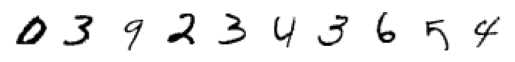

tensor([0, 3, 9, 2, 3, 4, 3, 6, 5, 4])

In [7]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis("off")
    plt.imshow(x[idx, :, :, :].reshape(28,28), cmap="gray_r")
plt.show()
y[:10]

In [21]:
# 모델구조설계
class MnistCNN(nn.Module):
    def __init__(self): # 주로 층을 만듬
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear( 7 * 7 * 16, 32 )
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view( -1, 7 * 7 * 16 )
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim= 1)
        return x

In [22]:
#학습 도구 구성
model = MnistCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

MnistCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [23]:
# 훈련함수 만들기(학습설계)
def train(model, train_loder, optimizer):
    model.train() # train_mode로 설정
    for idx, (images, labels) in enumerate(train_loder):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 187 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [26]:
for epoch in range(10):
    
    train(model=model, train_loder=train_loder, optimizer=optimizer)
    loss, acc = evaluate(model, test_loder)
    print(f"Epoch : {epoch+1}, Loss: {loss}, Accuracy: {acc}")
    

Batch : 0, Loss : 0.028828846290707588
Batch : 187, Loss : 0.09765230119228363
Batch : 374, Loss : 0.02422894723713398
Batch : 561, Loss : 0.021124253049492836
Batch : 748, Loss : 0.17190662026405334
Batch : 935, Loss : 0.08469349145889282
Batch : 1122, Loss : 0.023735785856842995
Batch : 1309, Loss : 0.10003531724214554
Batch : 1496, Loss : 0.10265185683965683
Batch : 1683, Loss : 0.0857224389910698
Batch : 1870, Loss : 0.04086346924304962
Epoch : 1, Loss: 0.054762074916809796, Accuracy: 0.9818
Batch : 0, Loss : 0.046967051923274994
Batch : 187, Loss : 0.0390792116522789
Batch : 374, Loss : 0.06622163951396942
Batch : 561, Loss : 0.023813148960471153
Batch : 748, Loss : 0.08781184256076813
Batch : 935, Loss : 0.08032164722681046
Batch : 1122, Loss : 0.10640569031238556
Batch : 1309, Loss : 0.07305064797401428
Batch : 1496, Loss : 0.003842936595901847
Batch : 1683, Loss : 0.226053848862648
Batch : 1870, Loss : 0.346388578414917
Epoch : 2, Loss: 0.04308586876997724, Accuracy: 0.9855
Bat

In [25]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # 평가모드로 설정 -> batch_normalization, drop_out 수행 중지
    with torch.no_grad(): #가중치 업데이터 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim = True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total = loss_total / ( len(test_dataset) / 32 )
    # loss_total /= ( len(test_dataset) / 32 )

    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy

In [27]:
evaluate(model = model, test_loader = test_loder)

(0.0418761555605568, 0.9868)